# Import Modules

In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sn
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import time
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Used for importing the model
import urllib.request
import tarfile
import zipfile
import sys
import os
import pickle
import random

from IPython.display import Image, display

# Define Key Values
We have a lot of files we need to setup to load the model and prepare it for transfer learning. In this block we define file and folder names for pulling data from the model we're downloading/downloaded.

model_url: url for the inception model freely available from google. The model will be loaded from here
model_directory: directory which we want to put our model files at
map_id_to_class: file that maps out the dataset ids to classes
map_id_to_name: file that maps out the dataset id to class names

The second block of strings are names that are already defined in the model. Here we're defining them so we can later access those tensors for future use, such as connecting a layer to a newly made layer



In [2]:
# Define Model
model_url = "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz"
model_directory = "inception"
map_id_to_class  = "imagenet_2012_challenge_label_map_proto.pbtxt"
map_id_to_name = "imagenet_synset_to_human_label_map.txt"
map_graph_def = "classify_image_graph_def.pb"

#tensors used later for transfer learning
bottleneck_tensor_name = 'pool_3:0'
jpeg_tensor_name = 'DecodeJpeg/contents:0'
jpeg_tensor_input_name = 'DecodeJpeg:0'
resized_input_tensor_name = 'ResizeBilinear:0'
softmax_tensor_name = "softmax:0"
softmax_tensor_logits_name = 'softmax/logits:0'

# Data
Here we define the folder the data is in as well as indicate the number of channels the images will be and the size as which to process them. The model we are downloading has a variable size input so we can give it any sized images we want, and it will resize them internally when processing.

In [3]:
# Define Dataset
data_directory = "/256_ObjectCategories/"
#data_directory = "/birds/"
image_size = 32
num_channels = 3
num_classes = 257

In [4]:
def download(url, directory):
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = url.split('/')[-1]
    filepath = os.path.join(directory, filename)
    if not os.path.exists(filepath):
    
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' %
                           (filename,
                            float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
    
        filepath, _ = urllib.request.urlretrieve(url,filepath,  _progress)
        print("")
        statinfo = os.stat(filepath)
    else:
        print('File already downloaded')
    tarfile.open(filepath, 'r:gz').extractall(directory)

### Map ImageNet Class IDs to Names
This code takes in the id to name mapping file. We need to processes each line into two separate elements.
For each line there is an id followed by a tab followed by a class name followed by a newline character. We can simply strip out the newline and separate the elements between the tab to have separated ids and names. 
Gor example: 'n15102894\tknothole\n' -> 'n15102894', 'knothole'

In [5]:
id_to_name = {}  
    
path = os.path.join(model_directory, map_id_to_name)
with open(file=path, mode='r') as file:
    #read entire file
    lines = file.readlines()
    for line in lines:
        #strip out new line
        line = line.replace("\n", "")
        #get token strings between tab character
        tokens = line.split("\t")
        #get token ids and names
        uid = tokens[0]
        name = tokens[1]
        #each name is accessed via its id
        id_to_name[uid] = name

### Map ImageNet Class IDs to Class values
This code takes in the id to class value mapping file. Each mapping is formatted in the fashion of entry {target_class: value target_class_string: "stringID"}. The formatting is a little bit messier than the previous mapping so we'll look at each token and try to find target_class and target_class_string and insert the values into a dictionary.

In [6]:
id_to_class = {}  
class_to_id = {}  

path = os.path.join(model_directory, map_id_to_class)
with open(file=path, mode='r') as file:
    # read entire file
    lines = file.readlines()

    for line in lines:
        if line.startswith("  target_class: "):
            #split and grad second token as value
            tokens = line.split(": ")
            uclass = int(tokens[1])

        elif line.startswith("  target_class_string: "):
            # get tokens
            tokens = line.split(": ")
            # second token is the string
            uid = tokens[1]
            # strip quotations from token
            uid = uid[1:-2]
            # add to dictionary
            id_to_class[uid] = uclass
            class_to_id[uclass] = uid

# Build Graph
With the model downloaded we can build the model in the tensorflow graph. GraphDef() has a simple ParseFromString function we can use to have it build the .pd model file.

In [7]:
graph = tf.Graph()

with graph.as_default():

    path = os.path.join(model_directory, map_graph_def)
    with tf.gfile.FastGFile(path, 'rb') as file:
        
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(file.read())

        #remember to set name to empty string else it doesn't work
        tf.import_graph_def(graph_def, name='')

## Access Tensors and Enable Session
Here we get references to tensors that we will needs for various cases. For instance the y_output and y_logits tensors are used to output predictions of the original model. The bottleneck tensors are used for outputting the "bottleneck layer" into a cache, which can then be used as input for a new final classification layer using transfer learning. This will be discussed later

In [8]:
# Get the output of the Inception model by looking up the tensor
# with the appropriate name for the output of the softmax-classifier.
y_output = graph.get_tensor_by_name(softmax_tensor_name)

# Get the unscaled outputs for the Inception model (aka. softmax-logits).
y_logits = graph.get_tensor_by_name(softmax_tensor_logits_name)

# Get the tensor for the last layer of the graph, aka. the transfer-layer.
bottleneck_layer = graph.get_tensor_by_name(bottleneck_tensor_name)

# Get the number of elements in the transfer-layer.
bottleneck_length = bottleneck_layer.get_shape()[3]

## Enable Session to use Graph

In [9]:
# Create a TensorFlow session for executing the graph.
session = tf.Session(graph=graph)

### Classification Helper Functions
These next three functions are for running classification on the model

In [10]:
def predictClass(image_path):
    image_data = tf.gfile.FastGFile(image_path, 'rb').read()
        
    prediction = session.run(y_output, feed_dict={jpeg_tensor_name: image_data})

    return np.squeeze(prediction)

In [11]:
def calculateScore(predictions, amount):
    #sorting the predictions
    prediction_args_sorted = predictions.argsort()
    prediction_percent = np.sort(predictions)[:amount:-1]
    topWinners = prediction_args_sorted[::-1]
    i=0
    for winner in topWinners[:amount]:
        uid = class_to_id[winner]
        name = id_to_name[uid].split(",")[0]
        print('%.4f' % prediction_percent[i] + " " + name)
        i+=1

In [12]:
def classify(image_path, amount):
    image_path = os.path.join(model_directory, image_path)
    display(Image(image_path))
    calculateScore(predictClass(image_path), amount)

## Classify JPEG images
From here we have enough code to start running predictions on the model. With what we have we can simply take any jpg image and feed it to the model. My example has it predict what the forklift image is. I used a forklift as that is actually 1 of the 1000 classes that the model originally trained on.

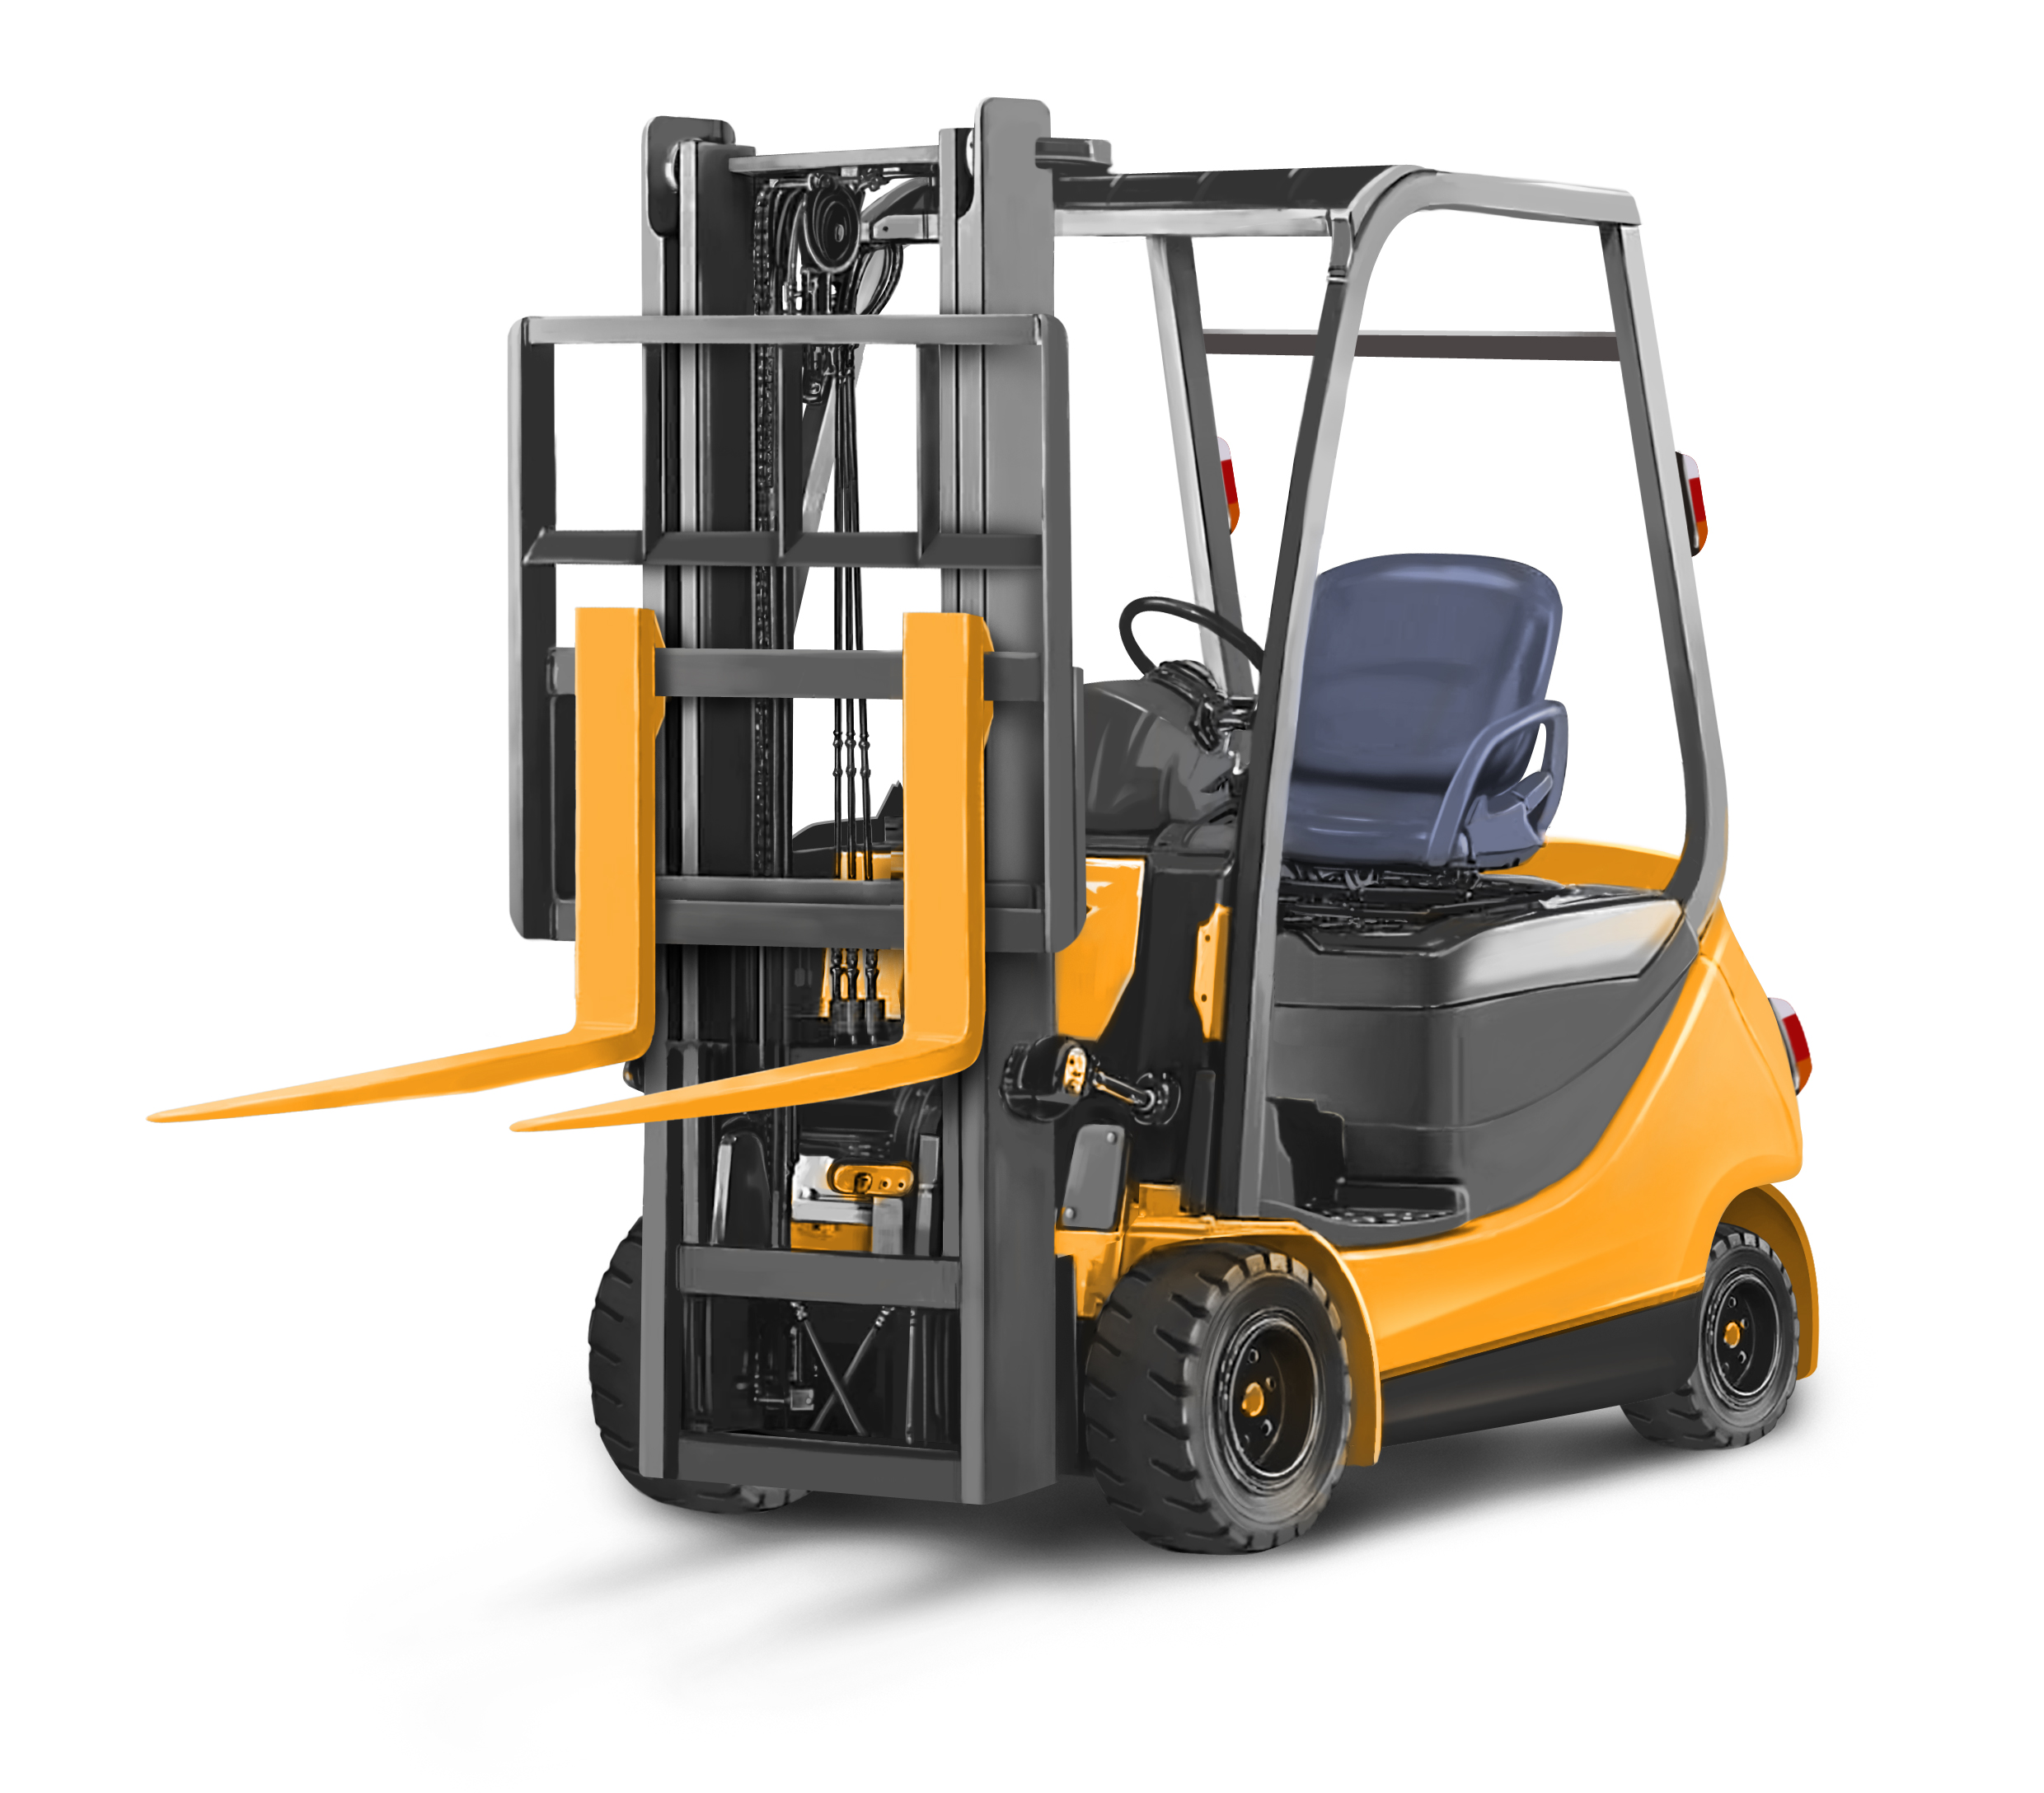

0.9826 forklift
0.0002 barbell
0.0002 tractor
0.0002 crane
0.0001 golfcart


In [13]:
classify('Forklift-Truck.jpg', 5)

Now lets have it predict something that it wasn't trained on. In the birds database I've selected an owl. We'll see that it thinkgs it's a sulphur-crested cockatoo, followed by a kite. Obviously this is neither, though it is a bird that flies! Interesting how it thinks its a bird even though it hasn't trained with owls. Now what if you really wanted to classify birds. This large network has a lot of power in it, and can classify some of them, but it doesn't have the classification you exactly want. You have a few things you could do.

You could create your own model that outputs probability of the bird classes you want to test.
You can just use the model as is with the limited output you care about.
You can harness the learned features of the larger network, and build a new output layer with your own classes. This is called transfer learning.

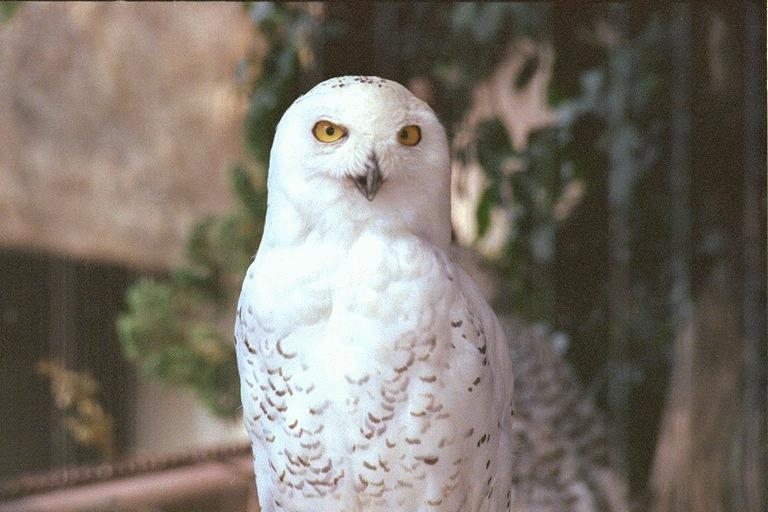

0.3321 sulphur-crested cockatoo
0.2836 kite


In [14]:
something = classify('birds/'+'owl/owl004.jpg', amount=2)

# Transfer Learning

In [15]:
def bottleneckCache(cache_path, image_paths=None):
    if os.path.exists(cache_path):
    # Load the cached data from the file.
        with open(cache_path, mode='rb') as file:
            bottleneck_values = pickle.load(file)

        print("Data loaded: " + cache_path)
    else:
        # No cache file. Make it.
        num_images = len(image_paths)
        # allocate memory in advance
        bottleneck_values = [None] * num_images

        # For each input image.
        for i in range(num_images):
            bottleneck_values[i] = getBottleneckValues(image_path=os.path.abspath(model_directory + data_directory+image_paths[i]))
        
        with open(cache_path, mode='wb') as file:
            pickle.dump(np.array(bottleneck_values), file)

        print("Data saved: " + cache_path)

    return bottleneck_values

In [16]:
def getBottleneckValues(image_path):
    image_data = tf.gfile.FastGFile(image_path, 'rb').read()
    bottleneck_values = session.run(bottleneck_layer, feed_dict={jpeg_tensor_name: image_data})

    return np.squeeze(bottleneck_values)

In [17]:
def getFiles(dire):
    r= []
    for root, dirs, files in os.walk(dire):
        if dirs:
            names = dirs
        for name in files:
            r.append((root.split(os.path.sep)[-1] + "/" + name, root.split(os.path.sep)[-1]))
    return r, names

In [18]:
output, label_names = getFiles(os.path.abspath(model_directory + data_directory))

images = [x[0] for x in output]
labels = [x[1] for x in output]

In [19]:
bottleneck_values = bottleneckCache(cache_path=os.path.abspath('257Dataset.pkl'),image_paths=images)

# zip data
zipped_values = list(zip(images, labels, bottleneck_values))

#shuffle the data
random.shuffle(zipped_values)

#unzip new shuffled data
images, labels, bottleneck_values = zip(*zipped_values)

Data loaded: C:\Users\Seth\CNNTutorials\5. TransferLearning_Tutorial\257Dataset.pkl


In [20]:
labels

('198.spider',
 '033.cd',
 '257.clutter',
 '035.cereal-box',
 '219.theodolite',
 '176.saddle',
 '205.superman',
 '150.octopus',
 '136.mandolin',
 '105.horse',
 '245.windmill',
 '219.theodolite',
 '240.watch-101',
 '191.sneaker',
 '095.hamburger',
 '092.grapes',
 '162.picnic-table',
 '119.jesus-christ',
 '246.wine-bottle',
 '008.bathtub',
 '139.megaphone',
 '006.basketball-hoop',
 '177.saturn',
 '221.tomato',
 '228.triceratops',
 '104.homer-simpson',
 '019.boxing-glove',
 '238.video-projector',
 '087.goldfish',
 '145.motorbikes-101',
 '171.refrigerator',
 '195.soda-can',
 '232.t-shirt',
 '163.playing-card',
 '251.airplanes-101',
 '251.airplanes-101',
 '257.clutter',
 '220.toaster',
 '075.floppy-disk',
 '018.bowling-pin',
 '257.clutter',
 '042.coffin',
 '196.spaghetti',
 '208.swiss-army-knife',
 '111.house-fly',
 '143.minaret',
 '224.touring-bike',
 '166.praying-mantis',
 '046.computer-monitor',
 '155.paperclip',
 '162.picnic-table',
 '178.school-bus',
 '021.breadmaker',
 '250.zebra',
 '

In [21]:
mydict = {}
label_names
i=0
for name in label_names:
    mydict[name] = i
    i += 1

In [22]:
# Converts label name to a one hot vector
# eg: if you had classes cat and dog, and an image was the dog, it's label would be [0, 1]
def labelNamesToValues(labels):
    list_of_labels = []
    one_hot_labels = [0] * len(mydict.values())
    for label in labels:
        new_list = one_hot_labels[:]
        print(label)
        new_list[mydict[label]] = 1
        list_of_labels.append(new_list)
        
    return list_of_labels

In [23]:
label_values = labelNamesToValues(labels)

198.spider
033.cd
257.clutter
035.cereal-box
219.theodolite
176.saddle
205.superman
150.octopus
136.mandolin
105.horse
245.windmill
219.theodolite
240.watch-101
191.sneaker
095.hamburger
092.grapes
162.picnic-table
119.jesus-christ
246.wine-bottle
008.bathtub
139.megaphone
006.basketball-hoop
177.saturn
221.tomato
228.triceratops
104.homer-simpson
019.boxing-glove
238.video-projector
087.goldfish
145.motorbikes-101
171.refrigerator
195.soda-can
232.t-shirt
163.playing-card
251.airplanes-101
251.airplanes-101
257.clutter
220.toaster
075.floppy-disk
018.bowling-pin
257.clutter
042.coffin
196.spaghetti
208.swiss-army-knife
111.house-fly
143.minaret
224.touring-bike
166.praying-mantis
046.computer-monitor
155.paperclip
162.picnic-table
178.school-bus
021.breadmaker
250.zebra
227.treadmill
040.cockroach
212.teapot
053.desk-globe
243.welding-mask
200.stained-glass
168.raccoon
166.praying-mantis
152.owl
159.people
248.yarmulke
109.hot-tub
012.binoculars
145.motorbikes-101
027.calculator
240.w

### Separate Data into Train and Validate Lists

In [24]:
#define train/validate split
ratio = .66

total_size = len(bottleneck_values)
split = np.floor(ratio * total_size)
split = split.astype(int)

train_x = bottleneck_values[:split]
train_y = label_values[:split]
validation_x = bottleneck_values[split:]
validation_y = label_values[split:]

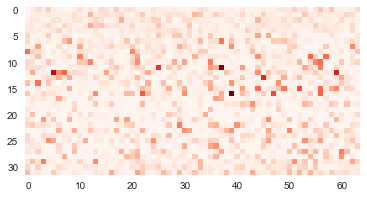

In [25]:
img = bottleneck_values[0]
img = img.reshape((32, 64))
_, ax = plt.subplots()
ax.grid(False)
plt.imshow(img, interpolation='nearest', cmap='Reds')
plt.savefig('bottleneckValue.jpg')

# Create new Classification Layer

In [26]:
with graph.as_default():
    
    x_input = tf.placeholder(tf.float32, shape=[None, bottleneck_length])
    y_output = tf.placeholder(tf.float32, shape=[None, num_classes])
    y_output_class = tf.argmax(y_output, dimension=1)
    
    num_epochs=50
    batch_size = 128
    
    global_step = tf.Variable(0, trainable=False)
    #learning rate
    learning_rate = tf.train.exponential_decay(.01, global_step, num_epochs, 0.90, staircase = True)
    
    with tf.variable_scope('newfc'):
        weights = tf.get_variable('weights', shape=[bottleneck_length, num_classes],
                                 initializer = tf.contrib.layers.xavier_initializer())
        biases = tf.get_variable('biases', shape=[num_classes], initializer=tf.constant_initializer(0))

        matrix_multiply = tf.matmul(x_input, weights)

        y_out = tf.nn.bias_add(matrix_multiply, biases)
        
    y_class = tf.nn.softmax(logits=y_out)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_output, logits=y_out)
    cross_entropy_mean = tf.reduce_mean(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y_out,1), tf.argmax(y_output,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy_mean)

In [27]:
model_name = "blah"
model_filename = model_name + "Model50epochs.ckpt"
model_directory2 = os.getcwd() + "/Models/" + model_name
model_path = model_directory2 + "/" + model_filename

### Optimizer

In [28]:
def get_predictions_in_batches(X, session):

    p = session.run([y_out], feed_dict = {x_input : out})

    return p

In [29]:
def getTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return h, m, s

In [30]:
def batch(x_data,y_data=None, batches=1):
    x_temp = copy.deepcopy(x_data)
    y_temp = copy.deepcopy(y_data)
    length = len(x_temp)
    
    # return iterations
    for index in range(0, length, batches):
        if y_temp is None:
            yield x_temp[index:min(index + batches, length)]
        else:
            yield x_temp[index:min(index + batches, length)], y_temp[index:min(index + batches, length)]

In [31]:
start = time.time()
train_accuracy_list = []
valid_accuracy_list = []
time_list = []
epoch_list = []

print("TRAINING ")

with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for current_epoch in range(5):
        for x, y in batch(train_x, train_y, batch_size):
            feed_dict = {x_input: x, y_output: y}
            # training and optimizing
            session.run([optimizer], feed_dict = feed_dict)

        train_accuracy = accuracy.eval(feed_dict={x_input:train_x, y_output: train_y})
        train_accuracy_list.append(train_accuracy)
        valid_accuracy = accuracy.eval(feed_dict={x_input:validation_x, y_output: validation_y})
        valid_accuracy_list.append(valid_accuracy)
        
        current_time = time.time() - start
        hours, minutes, seconds = getTime(current_time)
        print("Epoch[%d]" % current_epoch + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f " % train_accuracy + " %f" % valid_accuracy)
        time_list.append(current_time)
        epoch_list.append(current_epoch)
        # Evaluate on test dataset.
    if not os.path.exists(model_directory2):
        os.mkdir(model_directory2)
    save_path = saver.save(session, model_path)

TRAINING 
Epoch[0]0: 0: 5 0.110842  0.116076
Epoch[1]0: 0:10 0.171436  0.175843
Epoch[2]0: 0:15 0.260941  0.260786
Epoch[3]0: 0:19 0.370198  0.360334
Epoch[4]0: 0:24 0.464653  0.450658


### Reload the session and run predictions
Here we want to load the model and session, and get predictions. In this case I'm getting the entire validation set.

In [32]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    load_path = saver.restore(session, model_path)
    prediction = session.run(y_class, feed_dict={x_input: validation_x})

In [33]:
predictions = []

for pred in prediction:
    predictions.append(pred.argmax())

In [34]:
predictions_true = []

for pred in validation_y:
    pred = np.asarray(pred)
    predictions_true.append(pred.argmax())

In [36]:
prediction

array([[  1.00000000e+00,   1.99301931e-09,   1.19099219e-09, ...,
          2.27221730e-09,   1.67689540e-09,   1.16595533e-09],
       [  9.98821795e-01,   4.51031201e-06,   3.81914788e-06, ...,
          3.86946294e-06,   3.42903013e-06,   5.11905318e-06],
       [  1.00000000e+00,   4.50525439e-09,   5.11785503e-09, ...,
          2.74428014e-09,   6.80987844e-09,   4.31463398e-09],
       ..., 
       [  1.00000000e+00,   2.28713137e-09,   3.53738860e-09, ...,
          2.11563811e-09,   7.56566099e-09,   2.73363332e-09],
       [  9.99566138e-01,   1.54742736e-06,   1.47585592e-06, ...,
          7.64156880e-07,   3.62417973e-06,   6.89733668e-07],
       [  9.99562442e-01,   2.13916178e-06,   3.50841015e-06, ...,
          1.50367214e-06,   1.19068977e-06,   8.81105052e-07]], dtype=float32)

In [42]:
def plotConfusionMatrix(labels, predictions, title_name, file_name):
           
    conf_mat = confusion_matrix(predictions_true, predictions)
    df_cm = pd.DataFrame(conf_mat, index = [i for i in label_names], columns = [i for i in label_names])
    plt.figure(figsize = (15,15))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
    plt.title(title_name)
    plt.savefig(file_name)

In [43]:
plotConfusionMatrix(predictions_true, predictions, 'Bird3 Dataset Confusion Matrix','Bird3_test.jpg')

ValueError: Shape of passed values is (1, 1), indices imply (6, 6)

## Displays 9 images with their label and model prediction

In [47]:
def plotPredictions(images, labels, predictions=None, filename=None):
    #plt.title('Classification of sample')
    for i, ax in enumerate(axes.flat):
        # Interpolation type.

        # Plot image.
        ax.imshow(img[i])
        ax.grid(False)    
        # Show true and predicted classes.
        if predictions is None:
            xlabel = "Label: {0}".format(labels[i])
        else:

            xlabel = "Label: {0}\nPred: {1}".format(label_names[labels[i]], label_names[predictions[i]])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        if filename is not None:
            plt.savefig(filename)

In [ ]:
index = 3

img = []
for i in range(index,index+9):
    img.append(mpimg.imread(os.path.abspath(model_directory + data_directory + images[i + split])));
    
cls_true = predictions_true[index:index+9];
preds = predictions[index:index+9]

fig, axes = plt.subplots(3, 3, figsize=(15,15));

plotPredictions(img, cls_true, preds)